# Lecture 10: Scientific programming in practice
Last lecture, we spoke about the theoretical backend of scientific programming tools. In this lecture, we use them in practice to solve real-world problems close to how they are solved in state of the art toolboxes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Case study: Optimisation

Optimisation problems are extremely common in real-world applications. From civil engineering and aerodynamics to finance and machine learning. It is even common in medicine and biotechnology. 

In this lecture, we will create a Python tool to solve general optimisation problems and use it to solve the multiple linear regression problem common in machine learning and statistics.

### Primer: Mathematical optimisation

In mathematical optimisation, we have a function, $f(\mathbf{x})$, that we wish to minimise. This funciton can represent a variety of quantities. For example, the risk of a financial investment (often described by the volatility of the stocks in the portfolio), the prediction error of a machine learning problem (often described by the sum of squared errors or cross entropy between the predicted and true labels) or the aerodynamical drag of a plane. Likewise, the variable, $\mathbf{x}$, represent the quantity we can vary in the optimisation problems. For investment risk minimisation, $\mathbf{x}$ represents the amount of shares in each stock, for machine learning problems, it represents the parameters of a mathematical model and for drag minimisation, $\mathbf{x}$ parametrises the geometry of our plane.

For now, we will just work with an abstract function $f(x) = x^2 -5x - 2$ whose global minimum we wish to find.

In [3]:
def f(x):
    return x**2 - 5*x -2

domain = np.linspace(-5, 5, 1001)

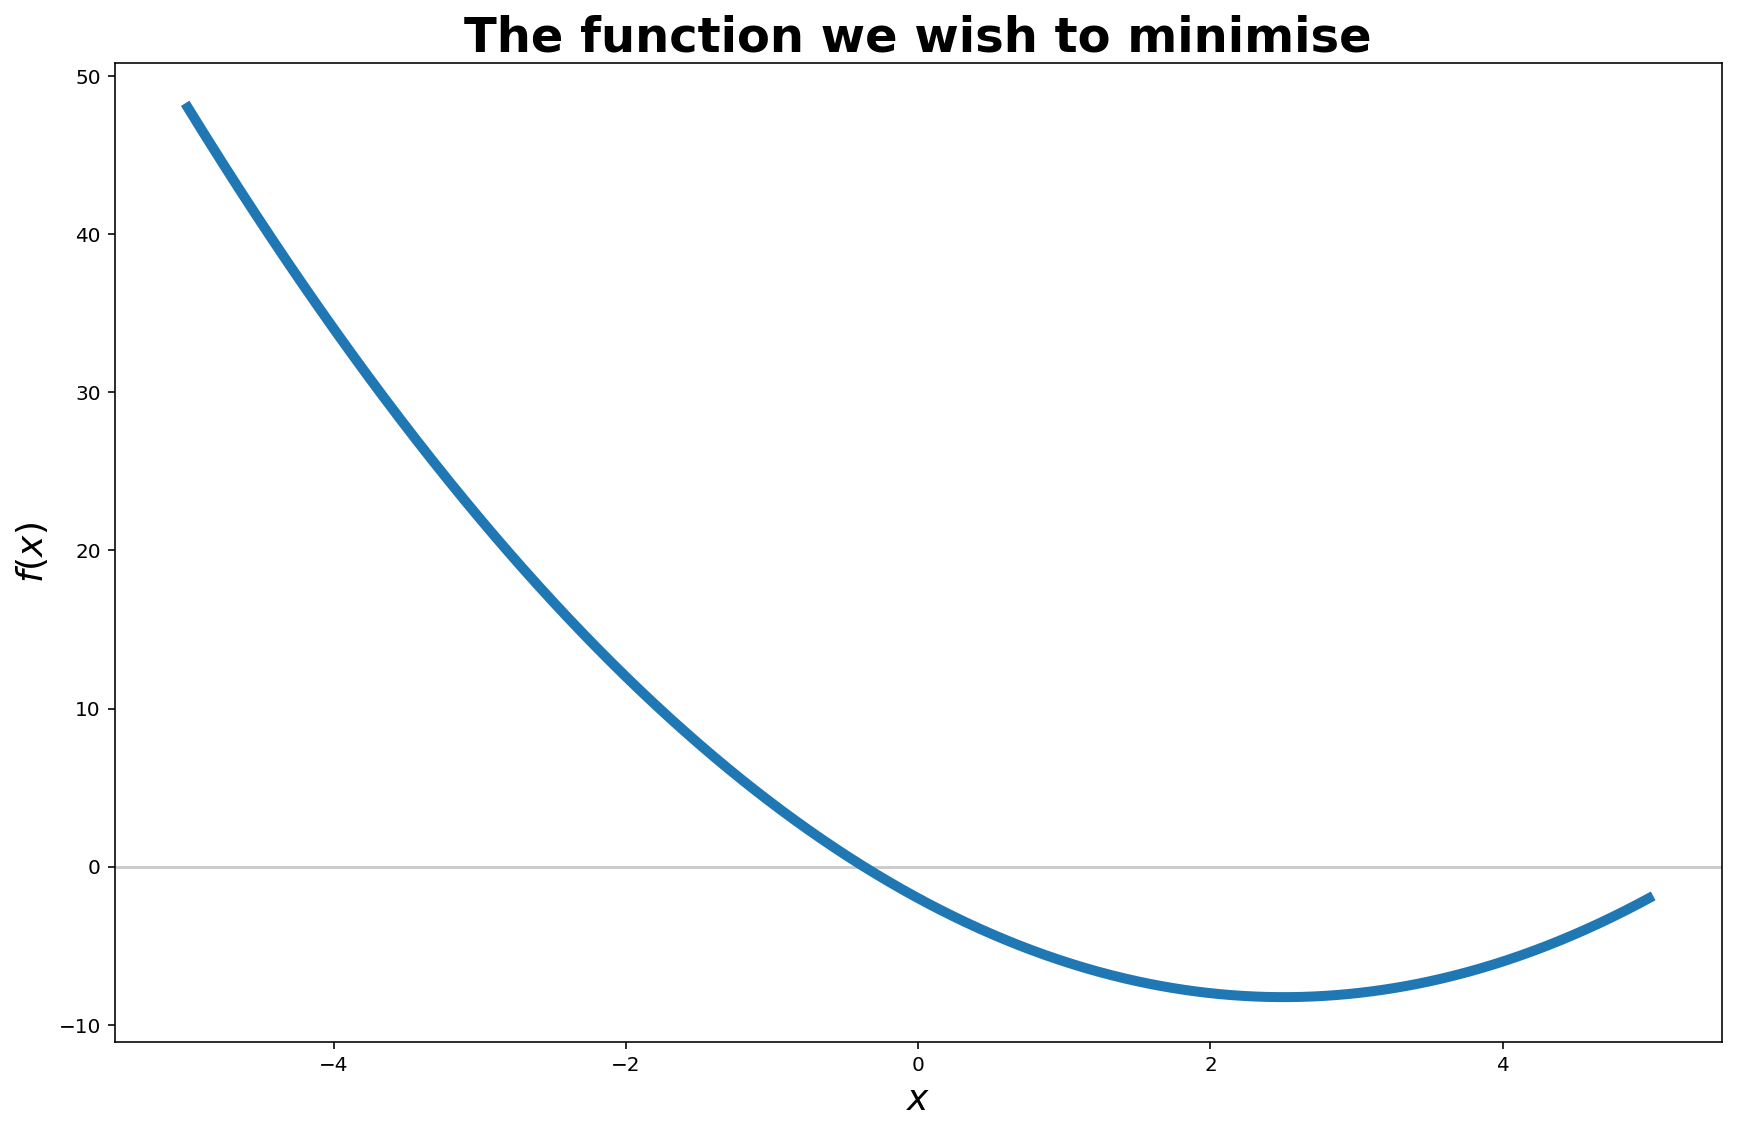

In [4]:
figure, ax = plt.subplots(figsize=(9*1.6, 9))

ax.plot(domain, f(domain), linewidth=5)
plt.axhline(0, zorder=-1, color=(0.8, 0.8, 0.8))
ax.set_xlabel('$x$', size=18, weight='bold')
ax.set_ylabel('$f(x)$', size=18, weight='bold')
ax.set_title('The function we wish to minimise', weight='bold', size=24)

del figure, ax

You might remember that we can find the minimum of a function, $f(\mathbf{x})$, by setting its gradient, $\nabla f(\mathbf{x})$ to zero. Therefore, it makes sense that we are interested in the gradient of our function. With our function above, the gradient is given by $\nabla f(\mathbf{x}) = 2x - 5$.

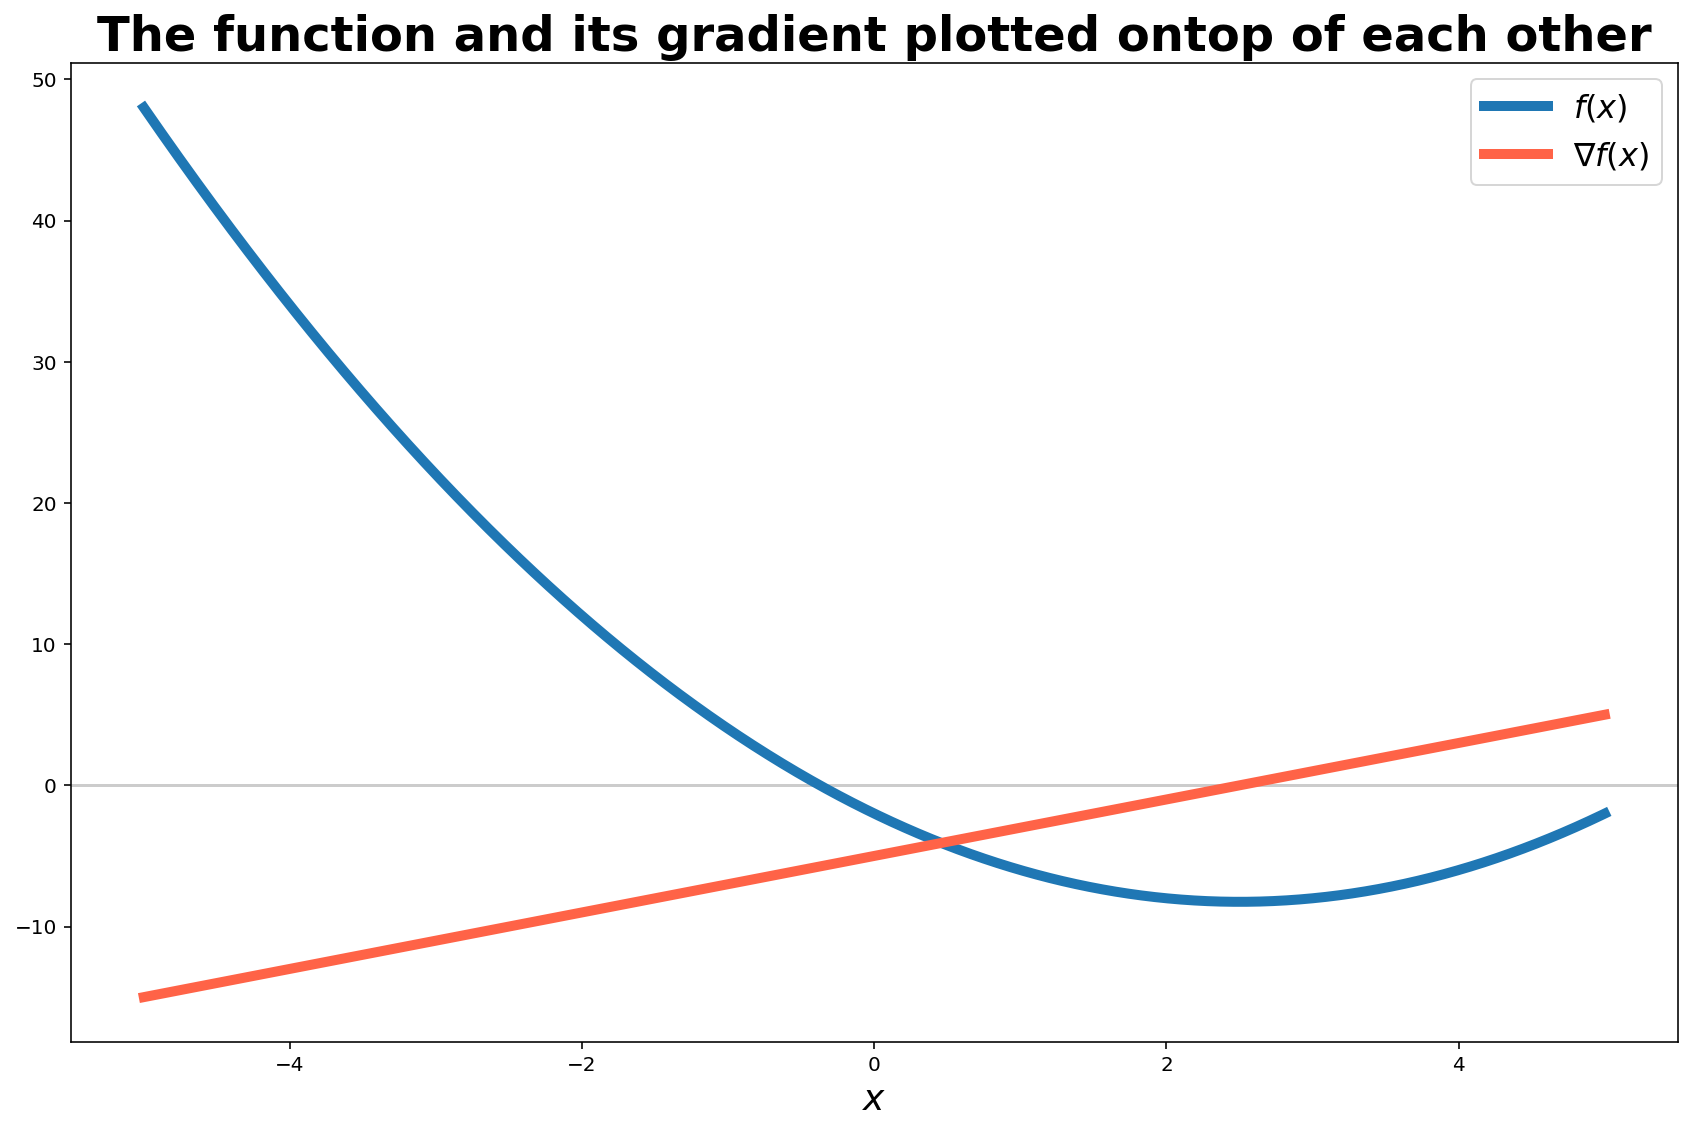

In [5]:
def dfdx(x):
    return 2*x - 5


figure, ax = plt.subplots(figsize=(9*1.6, 9))

ax.plot(domain, f(domain), linewidth=5, label='$f(x)$')
ax.plot(domain, dfdx(domain), linewidth=5, label=r'$\nabla f(x)$', color='tomato')
plt.axhline(0, zorder=-1, color=(0.8, 0.8, 0.8))
ax.set_xlabel('$x$', size=18, weight='bold')
ax.set_title('The function and its gradient plotted ontop of each other', weight='bold', size=24)
plt.legend(fontsize=16)

del figure, ax

In the example above, it was trivial to set the gradient to zero. However, for more realistic optimisation problem, this can be difficult — if not practically impossible. Therefore, we need some approximative method that we can use to find a point close to the minimum.

To do this, observe that the gradient is negative to the left of the minimum, and positive to the right of the optimum. If we represent the gradient as a 1D vector, then it points the opposite direction of the minimum!

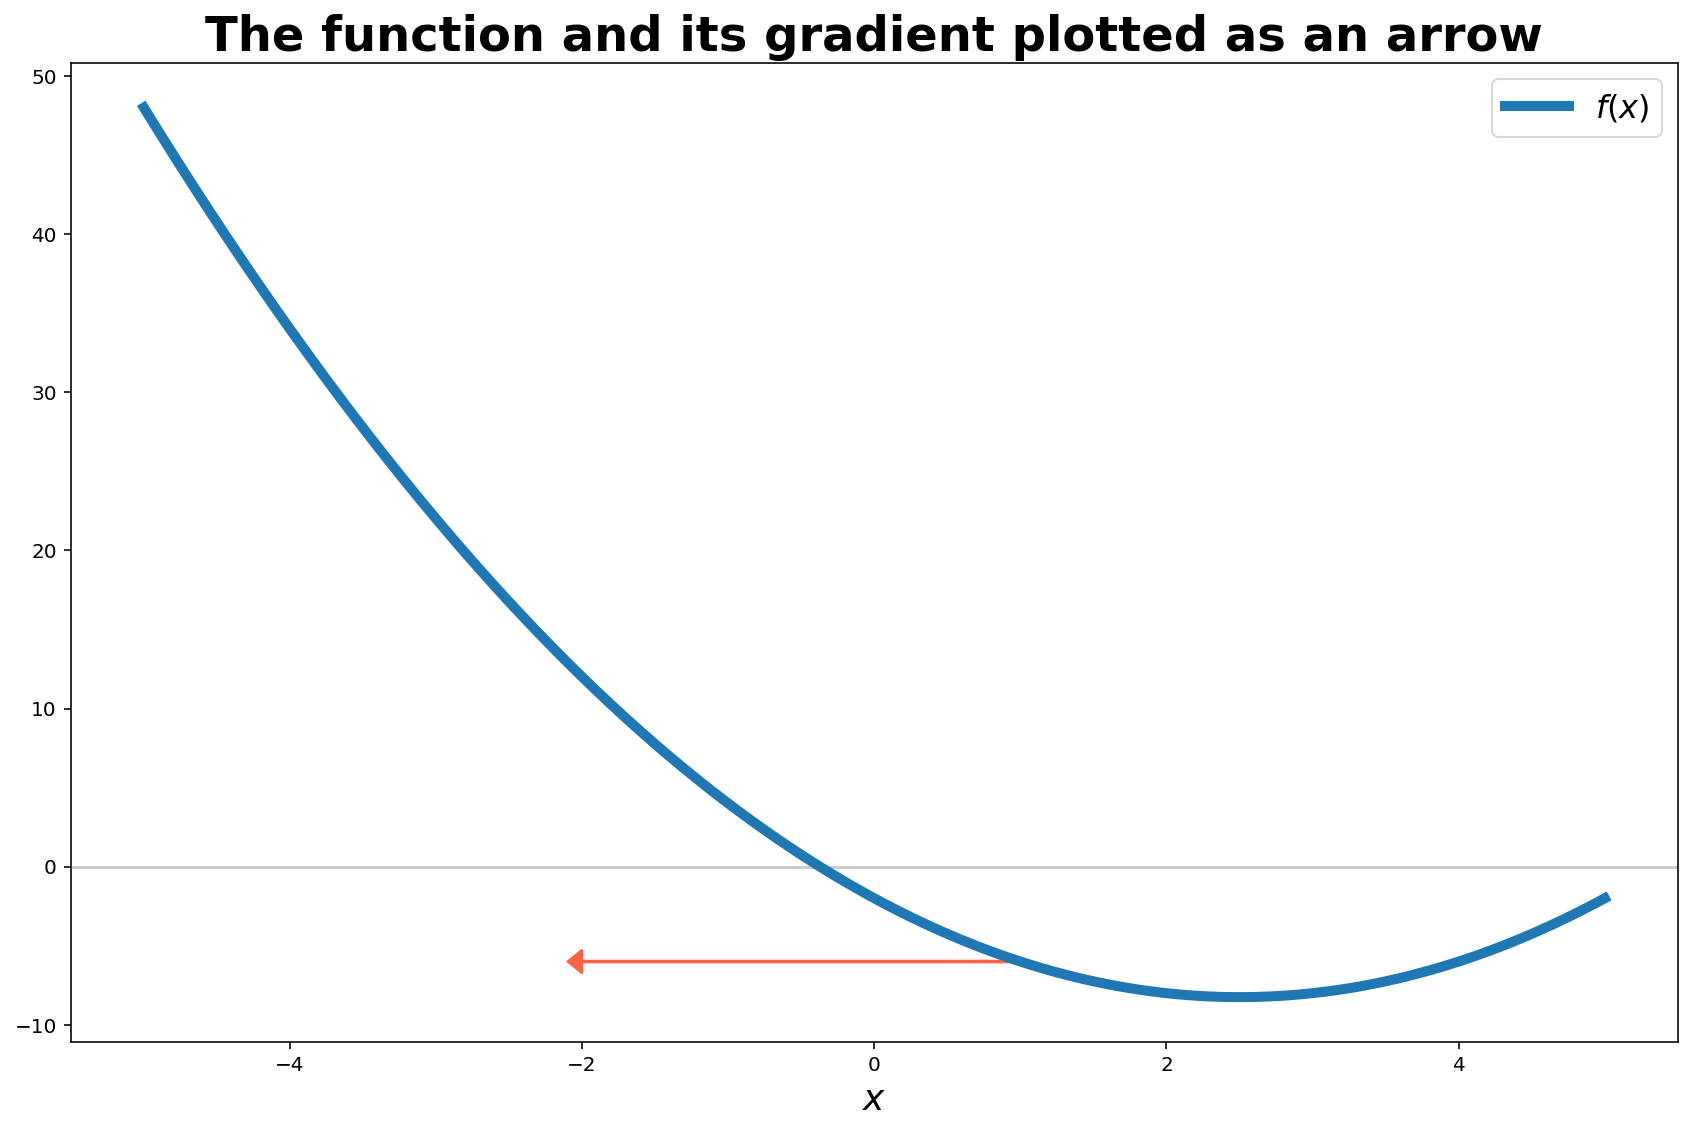

In [6]:
figure, ax = plt.subplots(figsize=(9*1.6, 9))

ax.plot(domain, f(domain), linewidth=5, label='$f(x)$')
ax.arrow(1, f(1), dfdx(1), 0, width=0.1, head_length=0.1, head_width=1.5, color='tomato', edgecolor=None)
plt.axhline(0, zorder=-1, color=(0.8, 0.8, 0.8))
ax.set_xlabel('$x$', size=18, weight='bold')
ax.set_title('The function and its gradient plotted as an arrow', weight='bold', size=24)
plt.legend(fontsize=16)

del figure, ax

This concept generalises to several dimensions. The gradient points in the direction of steepest ascent, and the oposite direction is the direction of steepest descent. We can therefore formulate the following algorithm

 * Start with an initial guess, $\mathbf{x}_0$ for the optimum $\mathbf{x}$ solving $\min f(\mathbf{x})$.
 * Repeat untill convergence:
   * $\mathbf{x}_{n+1} = \mathbf{x}_n - \eta \nabla f(\mathbf{x}_n)$
   
This surprisingly simple algorithm will always converge to the minimum of a function if the step-size (in machine learning this is called the learning rate), $\eta$ is chosen small enough. We also need a way to measure convergence, we know that the optimisation algorithm has converged when the gradient is zero, we can therefore say that the optimisation algorithm has converged when $||\nabla f(\mathbf{x})|| < \Delta$ for some convergence tolerance, $\Delta$.

### 2D visualisation of gradient descent

Let us once more visualise the gradient representing the direction of steepest ascent.

$$f(\mathbf{x}) = \mathbf{x}^T A \mathbf{x} + \mathbf{b}^T x + c$$

with gradient

$$\nabla f(\mathbf{x}) = 2A\mathbf{x} + \mathbf{b}$$

In [7]:
A = 0.1*np.array(
    [
        [2, 1],
        [1, 3]
    ]
)
b = 0.1*np.array([3, 2])
c = 0.1*5


@np.vectorize
def f(x, y):
    v = np.array([x, y])
    return v.T@(A@v) + b.T@v + c

@np.vectorize
def dfdx(x, y):
    v = np.array([x, y])
    return 2*A@v + b

domain_x, domain_y = np.mgrid[:100, :100]/10 - 5

Text(0.5, 1.0, '$f(\\mathbf{x})$ plotted as contour lines with the gradient as an arrow.')

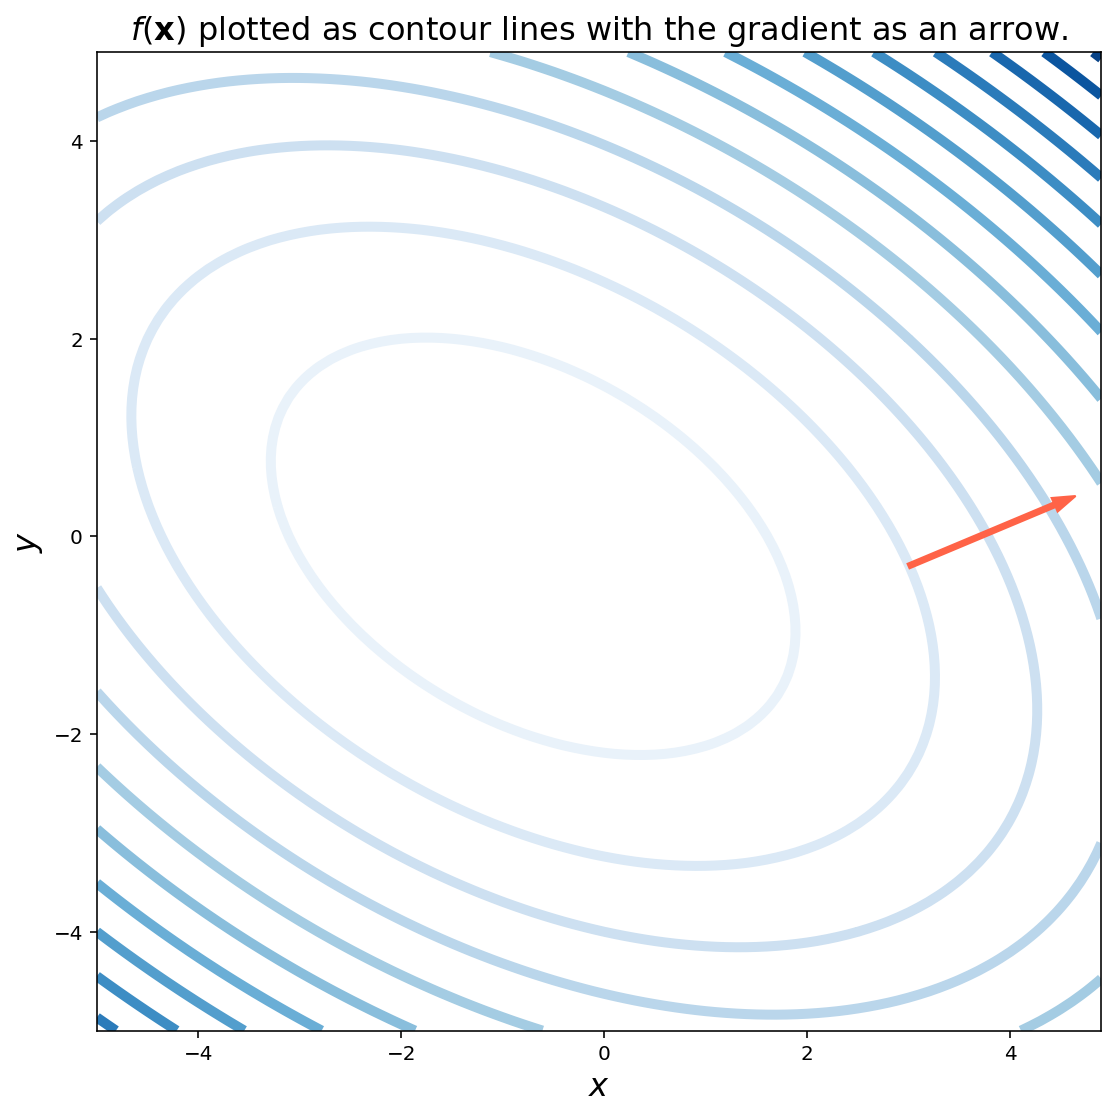

In [8]:
figure, ax = plt.subplots(figsize=(9, 9))

ax.contour(domain_x, domain_y, f(domain_x, domain_y), levels=15, linewidths=5, cmap='Blues')
ax.arrow(3, -0.3, *dfdx(3, -0.3), zorder=10, color='tomato', width=0.05)

ax.set_xlabel('$x$', size=16, weight='bold')
ax.set_ylabel('$y$', size=16, weight='bold')
ax.set_title('$f(\mathbf{x})$ plotted as contour lines with the gradient as an arrow.', size=16)

Now, let us visualise the gradient descent algorithm on this function. To do this exploratively, we create the following functions

In [9]:
def compute_positions(num_steps, step_length):
    positions = [None]*(num_steps+1)
    positions[0] = np.array((3, -0.3))
    for i in range(num_steps):
        positions[i+1] = positions[i] - step_length*dfdx(*positions[i])

    return positions

def plot_gradient_descent(num_steps, step_length, ax):
    positions = compute_positions(num_steps, step_length)

    ax.contour(domain_x, domain_y, f(domain_x, domain_y), levels=15, linewidths=5, cmap='Blues')
    for start, stop in zip(positions[:-1], positions[1:]):
        movement = stop-start
        ax.arrow(*start, *movement, zorder=10, color='tomato', width=0.05)

    ax.set_xlabel('$x$', size=16, weight='bold')
    ax.set_ylabel('$y$', size=16, weight='bold')
    ax.set_title('$f(\mathbf{x})$ plotted as contour lines with the gradient as an arrow.', size=16)

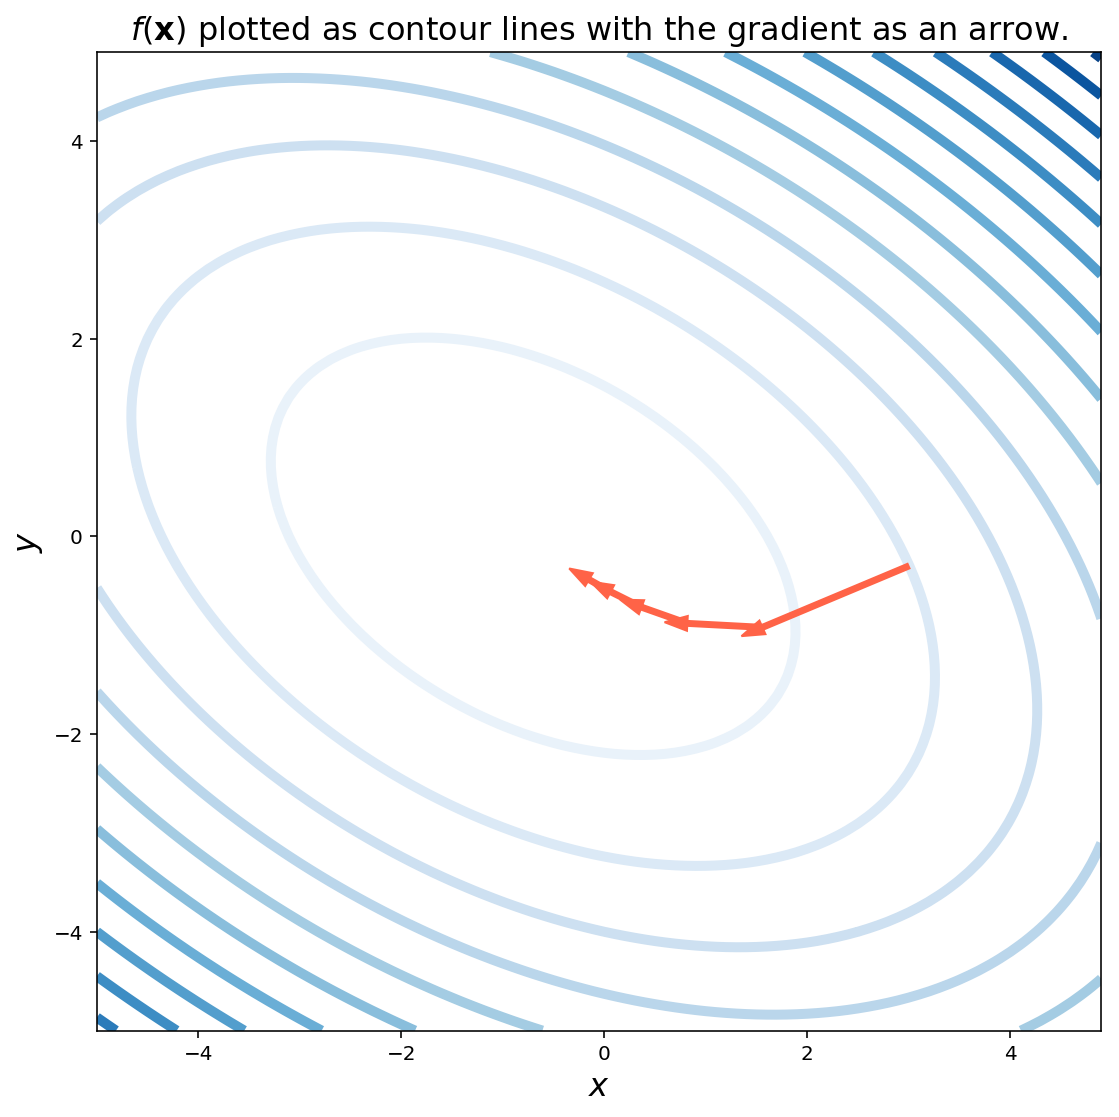

In [10]:
figure, ax = plt.subplots(figsize=(9, 9))

plot_gradient_descent(
    num_steps=5,
    step_length=1,
    ax=ax
)

del figure, ax

# Outline for program that will solve a general optimisation problem:


 * `GradientDescentOptimiser`:
    * `__init__(self, optimisation_problem, step_size, n_iter, tol)`
      * Specify the optimisation problem (defined below)
      * Specify the step size ($\eta$ above)
      * Specify the maximum number of iterations
      * Specify the convergence tolerance ($\Delta$ above)
      * Sets the initial guess to a random vector.
      * sets Has_converged to False
    * `gradient_step(self, x) -> new_x`
      * Takes a guess for the minimum, `x` and improves it with a single gradient step.
      * The input is not modified, rather, a new vector is returned.
    * `optimise(self)`:
      * Performs at most n optimisation steps
      * If it converges to the given tolerance before this, has_converged is updated
    * `function_value`
      * Returns the function value with the current minimum guess
    * `dfdx(self, x)`
      * Returns the gradient vector with the current minimum guess

We also define an interface for any input to the gradient descent optimiser
 * `MinimisationProblem` (interface):
   * `__init__(self, ...)`
     * Set the parameters of the optimisation problem
   * `__call__(self, x) -> f(x)`
     * Returns $f(\mathbf{x})$
   * `gradient(self, x) -> dfdx(x)`
     * Returns $\nabla f(\mathbf{x})$
   * `random_guess(self) -> random_x`
     * Returns a random guess for the minimum of the optimisation problem

In [55]:
class GradientDescentOptimiser:
    def __init__(self, optimisation_problem, step_size, n_iter, tol):
        self.optimisation_problem = optimisation_problem
        self.step_size = step_size
        self.n_iter = n_iter
        self.tol = tol
    
    def gradient_step(self, x):
        return x - self.step_size*self.dfdx(x)
    
    def optimise(self):
        for _ in range(self.n_iter):
            x = self.optimisation_problem.x
            self.optimisation_problem.x = self.gradient_step(x)
            
            if self.has_converged:
                break
    
    def function_value(self, x):
        return self.optimisation_problem(x)
    
    def dfdx(self, x):
        return self.optimisation_problem.gradient(x)
    
    @property
    def has_converged(self):
        x = self.optimisation_problem.x
        return np.linalg.norm(self.optimisation_problem.gradient(x)) < self.tol

### Multiple linear regression
Let us now implement a optimisation problem class that satisfies the interface that we defined above. The problem we are interested in is the multiple linear regression problem, given by
$$y_i \approx \sum_j x_ij w_j = \hat{y}$$
where $\mathbf{x}_i$ is a vector of measurements (e.g. age and height) for one subject and $y_i$ is the target we wish to predict for that subject (e.g. weight). The vector that we wish to find, $\mathbf{w}$ represents the relationship between our measurements and our target. If $\mathbf{w}_j$ is positive, then measurement $j$ is positively correlated with our target, and if it is negative, then it is negatively correlated with our target. 

Our goal is to find the  weights, $w_j$ that solves the problem above as best as possible. To do this, we use the sum of squared errors loss function to formulate a problem that we can solve:
$$ \min_\mathbf{w} \sum_i (y_i - \hat{y}_i)^2 = \min_\mathbf{w} \sum_i \left(\sum_j x_{ij} w_j - y_i\right)^2, $$
by using some linear algebra, we can reformulate this problem to be
$$ \min_\mathbf{w} ||\mathbf{y} - X\mathbf{w}||^2 = \min_\mathbf{w} L(\mathbf{w}; X, \mathbf{y})$$
where $\mathbf{y}$ is a vector whose $i$-th element is $y_i$, $X$ is a matrix whose $i, j$-th element is $x_{ij}$ and $\mathbf{w}$ is a vector whose $j$-th element is $w_j$.

Moreover, we can compute the gradient of $L$ with respect to $\mathbf{w}$ using some matrix calculus rules to get
$$\nabla_{\mathbf{w}} L(\mathbf{w}; X, \mathbf{y}) = X^T(X\mathbf{w} - y).$$

In [56]:
class LinearRegressionProblem:
    def __init__(self, data_matrix, target_vector):
        self.data_matrix = data_matrix
        self.target_vector = target_vector
        self.x = self.random_guess()
    
    def __call__(self, x):
        return np.sum((self.data_matrix@x - self.target_vector)**2)
    
    def gradient(self, x):
        return self.data_matrix.T@(self.data_matrix@x - self.target_vector)
    
    def random_guess(self):
        return np.random.standard_normal((self.data_matrix.shape[1], self.target_vector.shape[1]))

Let us test the linear regression solver

In [57]:
# Generate a random measurement matrix
data_matrix = np.random.standard_normal((100, 5))

# Generate some random correlations
weights = np.random.standard_normal((5, 1))

# Create target vector from this
target_vector = data_matrix@weights
noisy_target = target_vector + np.random.standard_normal(target_vector.shape)*0.01

In [58]:
# Create an optimisation problem
linear_regression_problem = LinearRegressionProblem(data_matrix, noisy_target)

# Create the optimiser
optimisation_problem = GradientDescentOptimiser(
    optimisation_problem=linear_regression_problem,
    step_size=0.01,
    n_iter=1000, 
    tol=1e-8
)

# Solve the problem
optimisation_problem.optimise()

if optimisation_problem.has_converged:
    print('The optimisation problem converged!')
else:
    print('The optimisation problem did not converge to the specified tolerance')

print('The relative error between the true weights and the discovered weights are:')
print((weights - linear_regression_problem.x))

The optimisation problem converged!
The relative error between the true weights and the discovered weights are:
[[0.00084472]
 [0.0010509 ]
 [0.00028907]
 [0.00013179]
 [0.00097379]]


### Ridge regression
A problem with multiple linear regression, is that we may "overfit" to our data. That is, find a model that fits very well with our measurements, but that perform poorly to new data. When this happens, we often find that model predicts a strong positive or negative correlation for most of our measurements. To prevent, this, we can use something called regularisation to make the linear regression model behave better. A popular method to accomplish this is via the Ridge regression problem, which has the following loss function:
$$L(\mathbf{w}; X, \mathbf{y}) = ||\mathbf{y} - X\mathbf{w}||^2 + \lambda ||\mathbf{w}||^2,$$
where the $||\mathbf{w}||^2$ term forces the correlation between our measurements and the target to be small and $\lambda$ is a parameter that specify how much we penalise high correlation. We must set the value of $\lambda$ manually.

In [59]:
class RidgeRegressionProblem(LinearRegressionProblem):
    def __init__(self, data_matrix, target_vector, regularisation_strength):
        super().__init__(data_matrix, target_vector)
        self.regularisation_strength = regularisation_strength
    
    def __call__(self, x):
        unregularised_function_value = super().__call__(x)
        regularisation_penalty = self.regularisation_strength*np.sum(x**2)
        return unregularised_function_value + regularisation_penalty
    
    def gradient(self, x):
        unregularised_gradient = super().gradient(x)
        regularisation_gradient = self.regularisation_strength*x
        return unregularised_gradient + regularisation_gradient

In [61]:
# Create an optimisation problem
ridge_regression_problem = RidgeRegressionProblem(data_matrix, noisy_target, 0.1)

# Create the optimiser
optimisation_problem = GradientDescentOptimiser(
    optimisation_problem=ridge_regression_problem,
    step_size=0.01,
    n_iter=1000, 
    tol=1e-8
)

# Solve the problem
optimisation_problem.optimise()

if optimisation_problem.has_converged:
    print('The optimisation problem converged!')
else:
    print('The optimisation problem did not converge to the specified tolerance')

print('The relative error between the true weights and the discovered weights are:')
print((weights - ridge_regression_problem.x)/weights)

The optimisation problem converged!
The relative error between the true weights and the discovered weights are:
[[ 1.95518984e-03]
 [-5.98213317e-04]
 [ 1.60941007e-03]
 [ 1.41502782e-03]
 [-6.40458203e-05]]


**But does the current class structure makes sense?**

No!

Currently, we say that Ridge regression is a special case of linear regression, but that is not the case. Rather, multiple linear regression is a special case of Ridge regression, where the regularisation parameter, $\lambda$ is set to 0. Let us refactor the code above to highlight this.

In [66]:
class RidgeRegressionProblem:
    def __init__(self, data_matrix, target_vector, regularisation_strength):
        self.data_matrix = data_matrix
        self.target_vector = target_vector
        self.regularisation_strength = regularisation_strength
        self.x = self.random_guess()
    
    def __call__(self, x):
        unregularised_function_value = np.sum(
            (self.data_matrix@w - self.target_vector)**2
        )
        regularisation_penalty = self.regularisation_strength*np.sum(x**2)
        return unregularised_function_value + regularisation_penalty
        
    
    def gradient(self, x):
        unregularised_gradient = (
            self.data_matrix.T@(self.data_matrix@x - self.target_vector)
        )
        regularisation_gradient = self.regularisation_strength*x
        return unregularised_gradient + regularisation_gradient
    
    def random_guess(self):
        return np.random.standard_normal((self.data_matrix.shape[1], self.target_vector.shape[1]))

class LinearRegressionProblem(RidgeRegressionProblem):
    def __init__(self, data_matrix, target_vector):
        super().__init__(data_matrix, target_vector, regularisation_strength=0)

Let's test the new Ridge regression class

In [67]:
# Create an optimisation problem
ridge_regression_problem = RidgeRegressionProblem(data_matrix, noisy_target, 0.1)

# Create the optimiser
optimisation_problem = GradientDescentOptimiser(
    optimisation_problem=ridge_regression_problem,
    step_size=0.01,
    n_iter=1000, 
    tol=1e-8
)

# Solve the problem
optimisation_problem.optimise()

if optimisation_problem.has_converged:
    print('The optimisation problem converged!')
else:
    print('The optimisation problem did not converge to the specified tolerance')

print('The relative error between the true weights and the discovered weights are:')
print((weights - ridge_regression_problem.x)/weights)

The optimisation problem converged!
The relative error between the true weights and the discovered weights are:
[[ 1.95518984e-03]
 [-5.98213317e-04]
 [ 1.60941007e-03]
 [ 1.41502782e-03]
 [-6.40458203e-05]]


Let's test the new multiple linear regression class

In [69]:
# Create an optimisation problem
linear_regression_problem = LinearRegressionProblem(data_matrix, noisy_target)

# Create the optimiser
optimisation_problem = GradientDescentOptimiser(
    optimisation_problem=linear_regression_problem,
    step_size=0.01,
    n_iter=1000, 
    tol=1e-8
)

# Solve the problem
optimisation_problem.optimise()

if optimisation_problem.has_converged:
    print('The optimisation problem converged!')
else:
    print('The optimisation problem did not converge to the specified tolerance')

print('The relative error between the true weights and the discovered weights are:')
print((weights - linear_regression_problem.x)/weights)

The optimisation problem converged!
The relative error between the true weights and the discovered weights are:
[[ 0.00066084]
 [-0.00222162]
 [ 0.00029937]
 [ 0.00011032]
 [-0.0010844 ]]
